In [211]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random as rand
#!pip install opencv-python
import cv2
import math

import tensorflow as tf
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


In [212]:
set_random_seed(3)

In [255]:
#Functions


from keras import backend as K

def oversampler(X, y):    
    X = list(X)
    counter = int(y.mean() * len(y))
    angles = [90, 180, 270]
    i = 0
    angle = 90
    while counter / len(y) < 0.5:
        for i in range(len(y)):
            if y[i] == 1:
                # get dims, find center
                image = X[i]
                (h, w) = image.shape[:2]
                (cX, cY) = (w // 2, h // 2)

                # grab the rotation matrix (applying the negative of the
                # angle to rotate clockwise), then grab the sine and cosine
                # (i.e., the rotation components of the matrix)
                M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
                cos = np.abs(M[0, 0])
                sin = np.abs(M[0, 1])

                # compute the new bounding dimensions of the image
                nW = int((h * sin) + (w * cos))
                nH = int((h * cos) + (w * sin))

                # adjust the rotation matrix to take into account translation
                M[0, 2] += (nW / 2) - cX
                M[1, 2] += (nH / 2) - cY

                # perform the actual rotation and return the image
                image = cv2.warpAffine(image, M, (nW, nH), False)

                X.append(image)
                y = np.append(y, y[i])
                counter += 1
            if counter / len(y) >= 0.5:
                break

        i += 1
        angle = angles[i%3]
    X = np.array(X)
    return X, y


In [256]:
dataset_path = "hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/"

In [257]:
train_labels = pd.read_csv(dataset_path + "labels_train.csv")


In [258]:
train_labels

,filename,FISSURE,REPARATION,FISSURE LONGITUDINALE,FAÏENCAGE,MISE EN DALLE
0,BDCAEROD0000000017183099_runway_3_gridsize_512...,0,0,1,1,0
1,BDCAEROD0000000017183055_runway_1_gridsize_512...,0,0,1,0,0
2,BDCAEROD0000000017183118_runway_1_gridsize_512...,1,0,1,0,0
3,BDCAEROD0000000017183028_runway_1_gridsize_512...,1,0,0,0,0
4,BDCAEROD0000000017183088_runway_1_gridsize_512...,0,0,0,0,0
...,...,...,...,...,...,...
825,BDCAEROD0000000017183055_runway_1_gridsize_512...,0,0,0,0,0
826,BDCAEROD0000000017183095_runway_1_gridsize_512...,1,1,1,0,1
827,BDCAEROD0000000017182994_runway_1_gridsize_512...,0,1,0,1,0
828,BDCAEROD0000000017183099_runway_3_gridsize_512...,0,1,1,1,0


In [259]:
train_image = []
for i in tqdm(range(train_labels.shape[0])):
    img = load_img(dataset_path + "train/" + train_labels["filename"][i], target_size=(224,224,3))
    img = img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 830/830 [00:05<00:00, 140.09it/s]


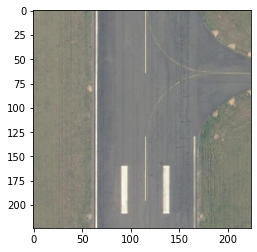

In [260]:
plt.imshow(X[145])


In [261]:
test_labels = pd.read_csv(dataset_path + "template_test.csv")


In [262]:
test_labels

,filename,FISSURE,REPARATION,FISSURE LONGITUDINALE,FAÏENCAGE,MISE EN DALLE
0,BDCAEROD0000000017183099_runway_2_gridsize_512...,0,0,0,0,0
1,BDCAEROD0000000017183016_runway_1_gridsize_512...,0,0,0,0,0
2,BDCAEROD0000000017183040_runway_1_gridsize_512...,0,0,0,0,0
3,BDCAEROD0000000017183010_runway_1_gridsize_512...,0,0,0,0,0
4,BDCAEROD0000000017183107_runway_2_gridsize_512...,0,0,0,0,0
...,...,...,...,...,...,...
195,BDCAEROD0000000017183053_runway_1_gridsize_512...,0,0,0,0,0
196,BDCAEROD0000000017183067_runway_1_gridsize_512...,0,0,0,0,0
197,BDCAEROD0000000017183053_runway_1_gridsize_512...,0,0,0,0,0
198,BDCAEROD0000000017183092_runway_2_gridsize_512...,0,0,0,0,0


In [263]:
test_images = []
for i in tqdm(range(test_labels.shape[0])):
    img = load_img(dataset_path + "test/" + test_labels["filename"][i], target_size=(224,224,3))
    img = img_to_array(img)
    img = img/255
    test_images.append(img)
test_images = np.array(test_images)


100%|██████████| 200/200 [00:01<00:00, 144.15it/s]


### One Model for Each Output

In [264]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')


for layer in base_model.layers:
    layer.trainable = False

In [265]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc', AUC()])

In [266]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [267]:
y_fissure = np.array(train_labels["FISSURE"])
y_reparation = np.array(train_labels["REPARATION"])
y_longi = np.array(train_labels["FISSURE LONGITUDINALE"])
y_faience = np.array(train_labels["FAÏENCAGE"])
y_med = np.array(train_labels["MISE EN DALLE"])

In [268]:
print(y_fissure.mean())
print(y_reparation.mean())
print(y_longi.mean())
print(y_faience.mean())
print(y_med.mean())
print(len(y_fissure))

0.30481927710843376
0.12530120481927712
0.26987951807228916
0.05903614457831325
0.13132530120481928
830


#### FISSURE

In [269]:
X_fissure_train, X_fissure_test, y_fissure_train, y_fissure_test = train_test_split(X, y_fissure, test_size=0.2)


In [228]:
X_fissure_train, y_fissure_train = oversampler(X_fissure_train, y_fissure_train) 

In [229]:
print(len(y_fissure_train))
print(y_fissure_train.mean())
print(X_fissure_train.shape)

930
0.5
(930, 224, 224, 3)


In [230]:
vgg1hist = model.fit(X_fissure_train, y_fissure_train, validation_data = (X_fissure_test, y_fissure_test), epochs = 20, batch_size = 32)


Epoch 1/20
30/30 [==============================] - 3s 69ms/step - loss: 0.6929 - acc: 0.7075 - auc_5: 0.7718 - val_loss: 0.8644 - val_acc: 0.4036 - val_auc_5: 0.6734
Epoch 2/20
30/30 [==============================] - 2s 52ms/step - loss: 0.5327 - acc: 0.7441 - auc_5: 0.8193 - val_loss: 0.9213 - val_acc: 0.6867 - val_auc_5: 0.7008
Epoch 3/20
30/30 [==============================] - 2s 54ms/step - loss: 0.4650 - acc: 0.7796 - auc_5: 0.8610 - val_loss: 0.8644 - val_acc: 0.4157 - val_auc_5: 0.7364
Epoch 4/20
30/30 [==============================] - 2s 53ms/step - loss: 0.3965 - acc: 0.8086 - auc_5: 0.8900 - val_loss: 1.2824 - val_acc: 0.3313 - val_auc_5: 0.7344
Epoch 5/20
30/30 [==============================] - 2s 53ms/step - loss: 0.3700 - acc: 0.8269 - auc_5: 0.9088 - val_loss: 1.3170 - val_acc: 0.3373 - val_auc_5: 0.7647
Epoch 6/20
30/30 [==============================] - 2s 54ms/step - loss: 0.3407 - acc: 0.8398 - auc_5: 0.9218 - val_loss: 1.0523 - val_acc: 0.6867 - val_auc_5: 0.772

In [231]:
fissure_pred = model.predict(test_images)
fissure_pred.reshape(200)
fissure_pred_1 = np.round(fissure_pred)
prior_adjusted_fissure_pred = np.round(fissure_pred * y_fissure.mean() / fissure_pred_1.mean())
prior_adjusted_fissure_pred = np.array([min(int(i), 1) for i in prior_adjusted_fissure_pred])
print(prior_adjusted_fissure_pred.mean())


0.295


#### REPARATION

In [232]:
X_reparation_train, X_reparation_test, y_reparation_train, y_reparation_test = train_test_split(X, y_reparation, test_size=0.2)


In [233]:
X_reparation_train, y_reparation_train = oversampler(X_reparation_train, y_reparation_train) 

In [234]:
print(len(y_reparation_train))
print(y_reparation_train.mean())
print(X_reparation_train.shape)

1166
0.5
(1166, 224, 224, 3)


In [235]:
vgg2hist = model.fit(X_reparation_train, y_reparation_train, validation_data = (X_reparation_test, y_reparation_test), epochs = 20, batch_size = 32)


Epoch 1/20
37/37 [==============================] - 2s 57ms/step - loss: 0.3259 - acc: 0.8979 - auc_5: 0.9438 - val_loss: 0.4318 - val_acc: 0.8434 - val_auc_5: 0.7052
Epoch 2/20
37/37 [==============================] - 2s 53ms/step - loss: 0.2392 - acc: 0.9091 - auc_5: 0.9588 - val_loss: 0.4385 - val_acc: 0.8193 - val_auc_5: 0.7251
Epoch 3/20
37/37 [==============================] - 2s 54ms/step - loss: 0.2013 - acc: 0.9228 - auc_5: 0.9692 - val_loss: 0.4094 - val_acc: 0.8614 - val_auc_5: 0.7142
Epoch 4/20
37/37 [==============================] - 2s 53ms/step - loss: 0.2048 - acc: 0.9254 - auc_5: 0.9681 - val_loss: 0.4239 - val_acc: 0.8614 - val_auc_5: 0.7473
Epoch 5/20
37/37 [==============================] - 2s 54ms/step - loss: 0.1824 - acc: 0.9357 - auc_5: 0.9732 - val_loss: 0.3945 - val_acc: 0.8554 - val_auc_5: 0.7630
Epoch 6/20
37/37 [==============================] - 2s 53ms/step - loss: 0.1674 - acc: 0.9365 - auc_5: 0.9781 - val_loss: 0.4013 - val_acc: 0.8735 - val_auc_5: 0.753

In [236]:
reparation_pred = model.predict(test_images)
reparation_pred.reshape(200)
reparation_pred_1 = np.round(reparation_pred)
print(reparation_pred_1.mean())
print(y_reparation.mean() / reparation_pred_1.mean())
prior_adjusted_reparation_pred = np.round(reparation_pred * y_reparation.mean() / reparation_pred_1.mean())
prior_adjusted_reparation_pred = np.array([min(int(i), 1) for i in prior_adjusted_reparation_pred])
print(prior_adjusted_reparation_pred.mean())

0.07
1.790017204083006
0.085


#### FISSURE LONGITUDINALE

In [184]:
X_longi_train, X_longi_test, y_longi_train, y_longi_test = train_test_split(X, y_longi, test_size=0.2)


In [185]:
X_longi_train, y_longi_train = oversampler(X_longi_train, y_longi_train) 

In [186]:
print(len(y_longi_train))
print(y_longi_train.mean())
print(X_longi_train.shape)

956
0.5
(956, 224, 224, 3)


In [243]:
vgg3hist = model.fit(X_longi_train, y_longi_train, validation_data = (X_longi_test, y_longi_test), epochs = 20, batch_size = 32)


Epoch 1/20
30/30 [==============================] - 2s 61ms/step - loss: 0.4560 - acc: 0.8274 - auc_5: 0.8936 - val_loss: 0.4618 - val_acc: 0.8133 - val_auc_5: 0.7984
Epoch 2/20
30/30 [==============================] - 2s 54ms/step - loss: 0.3843 - acc: 0.8410 - auc_5: 0.9064 - val_loss: 0.4384 - val_acc: 0.8133 - val_auc_5: 0.8085
Epoch 3/20
30/30 [==============================] - 2s 54ms/step - loss: 0.3151 - acc: 0.8713 - auc_5: 0.9318 - val_loss: 0.4248 - val_acc: 0.8434 - val_auc_5: 0.8264
Epoch 4/20
30/30 [==============================] - 2s 54ms/step - loss: 0.3126 - acc: 0.8588 - auc_5: 0.9319 - val_loss: 0.4364 - val_acc: 0.8434 - val_auc_5: 0.8252
Epoch 5/20
30/30 [==============================] - 2s 55ms/step - loss: 0.2871 - acc: 0.8745 - auc_5: 0.9432 - val_loss: 0.4120 - val_acc: 0.8434 - val_auc_5: 0.8350
Epoch 6/20
30/30 [==============================] - 2s 53ms/step - loss: 0.2713 - acc: 0.8881 - auc_5: 0.9481 - val_loss: 0.7927 - val_acc: 0.5602 - val_auc_5: 0.852

In [244]:
longi_pred = model.predict(test_images)
longi_pred.reshape(200)
longi_pred_1 = np.round(longi_pred)
print(longi_pred_1.mean())
print(y_longi.mean() / longi_pred_1.mean())
prior_adjusted_longi_pred = np.round(longi_pred * y_longi.mean() / longi_pred_1.mean())
prior_adjusted_longi_pred = np.array([min(int(i), 1) for i in prior_adjusted_longi_pred])
print(prior_adjusted_longi_pred.mean())

0.16
1.6867470256535413
0.235


#### FAIENÇAGE

In [237]:
X_faience_train, X_faience_test, y_faience_train, y_faience_test = train_test_split(X, y_faience, test_size=0.2)


In [238]:
X_faience_train, y_faience_train = oversampler(X_faience_train, y_faience_train) 

In [239]:
print(len(y_faience_train))
print(y_faience_train.mean())
print(X_faience_train.shape)

1256
0.5
(1256, 224, 224, 3)


In [241]:
vgg4hist = model.fit(X_faience_train, y_faience_train, validation_data = (X_faience_test, y_faience_test), epochs = 10, batch_size = 32)


Epoch 1/10
40/40 [==============================] - 2s 56ms/step - loss: 0.1735 - acc: 0.9554 - auc_5: 0.9793 - val_loss: 0.4210 - val_acc: 0.9157 - val_auc_5: 0.6501
Epoch 2/10
40/40 [==============================] - 2s 51ms/step - loss: 0.1353 - acc: 0.9626 - auc_5: 0.9811 - val_loss: 0.4007 - val_acc: 0.9217 - val_auc_5: 0.6574
Epoch 3/10
40/40 [==============================] - 2s 52ms/step - loss: 0.1201 - acc: 0.9674 - auc_5: 0.9850 - val_loss: 0.3487 - val_acc: 0.9217 - val_auc_5: 0.6611
Epoch 4/10
40/40 [==============================] - 2s 51ms/step - loss: 0.1100 - acc: 0.9682 - auc_5: 0.9859 - val_loss: 0.3511 - val_acc: 0.9157 - val_auc_5: 0.6692
Epoch 5/10
40/40 [==============================] - 2s 51ms/step - loss: 0.1082 - acc: 0.9674 - auc_5: 0.9877 - val_loss: 0.3947 - val_acc: 0.8614 - val_auc_5: 0.6926
Epoch 6/10
40/40 [==============================] - 2s 51ms/step - loss: 0.1101 - acc: 0.9682 - auc_5: 0.9862 - val_loss: 0.4204 - val_acc: 0.9217 - val_auc_5: 0.699

In [242]:
faience_pred = model.predict(test_images)
faience_pred.reshape(200)
faience_pred_1 = np.round(faience_pred)
print(faience_pred_1.mean())
prior_adjusted_faience_pred = np.round(faience_pred * y_faience.mean() / faience_pred_1.mean())
prior_adjusted_faience_pred = np.array([min(int(i), 1) for i in prior_adjusted_faience_pred])
print(prior_adjusted_faience_pred.mean())

0.1
0.01


#### MISE EN DALLE

In [245]:
X_med_train, X_med_test, y_med_train, y_med_test = train_test_split(X, y_med, test_size=0.2)

In [246]:
X_med_train, y_med_train = oversampler(X_med_train, y_med_train) 

In [247]:
print(len(y_med_train))
print(y_med_train.mean())
print(X_med_train.shape)

1168
0.5
(1168, 224, 224, 3)


In [248]:
vgg5hist = model.fit(X_med_train, y_med_train, validation_data = (X_med_test, y_med_test), epochs = 20, batch_size = 32)


Epoch 1/20
37/37 [==============================] - 3s 92ms/step - loss: 0.1656 - acc: 0.9349 - auc_5: 0.9811 - val_loss: 0.3760 - val_acc: 0.8494 - val_auc_5: 0.8778
Epoch 2/20
37/37 [==============================] - 2s 52ms/step - loss: 0.1466 - acc: 0.9461 - auc_5: 0.9842 - val_loss: 0.3025 - val_acc: 0.8735 - val_auc_5: 0.8915
Epoch 3/20
37/37 [==============================] - 2s 51ms/step - loss: 0.1232 - acc: 0.9478 - auc_5: 0.9884 - val_loss: 0.2811 - val_acc: 0.8976 - val_auc_5: 0.9001
Epoch 4/20
37/37 [==============================] - 2s 54ms/step - loss: 0.1123 - acc: 0.9563 - auc_5: 0.9913 - val_loss: 0.2815 - val_acc: 0.8855 - val_auc_5: 0.9039
Epoch 5/20
37/37 [==============================] - 2s 52ms/step - loss: 0.0892 - acc: 0.9675 - auc_5: 0.9940 - val_loss: 0.3394 - val_acc: 0.8855 - val_auc_5: 0.9001
Epoch 6/20
37/37 [==============================] - 2s 55ms/step - loss: 0.0931 - acc: 0.9580 - auc_5: 0.9939 - val_loss: 0.2803 - val_acc: 0.8976 - val_auc_5: 0.907

In [252]:
med_pred = model.predict(test_images)
med_pred.reshape(200)
med_pred_1 = np.round(med_pred)
print(med_pred_1.mean())
print(y_med.mean() / med_pred_1.mean())
prior_adjusted_med_pred = np.round(med_pred * y_med.mean() / med_pred_1.mean())
prior_adjusted_med_pred = np.array([min(int(i), 1) for i in prior_adjusted_med_pred])
print(prior_adjusted_med_pred.mean())

0.1
1.0369145
0.11


In [253]:
test_labels["FISSURE"] = prior_adjusted_fissure_pred
test_labels["REPARATION"] = prior_adjusted_reparation_pred
test_labels["FISSURE LONGITUDINALE"] = prior_adjusted_longi_pred
test_labels["FAÏENCAGE"] = prior_adjusted_faience_pred
test_labels["MISE EN DALLE"] = prior_adjusted_med_pred

test_labels 

,filename,FISSURE,REPARATION,FISSURE LONGITUDINALE,FAÏENCAGE,MISE EN DALLE
0,BDCAEROD0000000017183099_runway_2_gridsize_512...,0,0,0,0,0
1,BDCAEROD0000000017183016_runway_1_gridsize_512...,0,0,0,0,0
2,BDCAEROD0000000017183040_runway_1_gridsize_512...,1,0,0,0,0
3,BDCAEROD0000000017183010_runway_1_gridsize_512...,1,0,0,0,0
4,BDCAEROD0000000017183107_runway_2_gridsize_512...,0,0,0,0,0
...,...,...,...,...,...,...
195,BDCAEROD0000000017183053_runway_1_gridsize_512...,1,0,1,1,1
196,BDCAEROD0000000017183067_runway_1_gridsize_512...,1,0,1,0,0
197,BDCAEROD0000000017183053_runway_1_gridsize_512...,1,0,1,0,1
198,BDCAEROD0000000017183092_runway_2_gridsize_512...,1,0,0,0,0


In [254]:
test_labels.to_csv("predictions.csv", index=False)